<a href="https://colab.research.google.com/github/v-patel18/Data-Mining_Final-Project/blob/master/Pneumonia_Detection_Challenge_Trial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Install necessary packages
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

     |████████████████████████████████| 7.0MB 3.4MB/s 


In [0]:
#Use Kaggle API to download data
!pip3 install -q kaggle

In [0]:
#Import necessary libraries
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [0]:
# Use Kaggle credentials to download data
os.environ['KAGGLE_USERNAME']="vasvip"
os.environ['KAGGLE_KEY']="39829c7c09776b1754776f543a2459d1"

In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath('/Pneumonia_Detection')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'working')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [8]:
#Download dataset for the competition
!kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 39.9MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 51.3MB/s]
  0% 0.00/661k [00:00<?, ?B/s]
100% 661k/661k [00:00<00:00, 92.9MB/s]
 98% 371M/377M [00:03<00:00, 82.9MB/s]
100% 377M/377M [00:03<00:00, 116MB/s] 
100% 3.28G/3.29G [00:26<00:00, 124MB/s]
100% 3.29G/3.29G [00:26<00:00, 134MB/s]
  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 53.1kB/s]


In [0]:
# Unzip the downloaded files
!unzip -q -o stage_2_test_images.zip -d stage_2_test_images
!unzip -q -o stage_2_train_images.zip -d stage_2_train_images
!unzip -q -o stage_2_train_labels.csv.zip

## **Problem and Chosen Model**

RSNA Pneumonia Detection Challenge is a problem that requires for the detection of a bounding box that encompasses a pneumonia containing region. Hence, it is not a pure classification problem; it is rather a regression problem asking for the location and size of the region containing pneumonia in chest radiographs.

Regional Convolutional Neural Network (R-CNN) is a type of network that uses the ideas behind CNN to carry out the task of object detection. This is accomplished by proposing a number of boxes in a given image, and trying to identify if it belongs to any particular class of objects. Essentially, a R-CNN is composed of three different models: a CNN to generate image features, a classifier to predict the class of the object, and a regression model to precisely predict boundaries of the bounding box.

Although R-CNN does seem to be a good solution to the problem at hand, it is a rather slow algorithm. Faster, and more precise networks have been developed. One such network is the Mask R-CNN, an image segmentation algorithm, is capable of detecting objects at a pixel level, while also using a more efficient algorithm than R-CNN. 

Mask R-CNN is based on yet another implementation of R-CNN, called Faster R-CNN. This network first utilizes a CNN feature extractor to extract image features, followed by a region proposal network (RPN) to obtain regions of interest (RoI) in the image. Next, RoI pooling is applied to warp the images into fixed dimension, and lastly a fully connected network is used to make classifications and determine bounding box boundaries. 

Building on the Faster R-CNN, Mask R-CNN simply adds two more convolution networks at the end to gain the ability to create masks for objects. Additionally, these convolutional networks run in parallel with fully connected networks responsible for making classifications and determinig bounding box boundaries, hence conserving time. The image below shows the architecture of Mask-RCNN:
![alt text](https://cdn-images-1.medium.com/max/800/1*QaPtdVXIeIdFhbW0Ac7tNA.png)

Because Mask R-CNN is relatively faster, and has the ability to detect objects more precisely than an object detection network (such as Faster R-CNN), we chose to use Mask R-CNN for this competition.

**Install Matterport's Mask-RCNN implementation from GitHub**

In [10]:
os.chdir(ROOT_DIR)
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 119.70 MiB | 40.44 MiB/s, done.
Resolving deltas: 100% (555/555), done.
zip_safe flag not set; analyzing archive contents...


In [11]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [0]:
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_test_images')

####Parsing Files
Since all the images are stored in two sets of files (for test and train images), a code to parse the files is necessary.

get_dicom_fps returns a list of dicom image paths and filenames
parse_dataset returns image filenames and annotations dictionary (keyed by filenames)

In [0]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

DetectorConfig is the class containing all the parameters for the Mask R-CNN model, which can be overwritten to allow for different parameter configurations.



In [14]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet101'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    
    TRAIN_ROIS_PER_IMAGE = 32
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.8
    DETECTION_NMS_THRESHOLD = 0.01
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    STEPS_PER_EPOCH = 200 
    TOP_DOWN_PYRAMID_SIZE = 256
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

The following cell makes necessary changes in the DetectorDataset to allow the images to be processed.

Each function in the below cell is explained in the cell itself.

In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    #Function to start initialization
    #image_fps and image_annotations are the files containing the filepaths and image annotations
    #Orig_height and orig_width are the original dimensions of the images
    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes - define what the class represents
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images - describe the specifications of the images
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
    
    #Allow for easy referencing of image
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    #Load images from given files into the model using the pydicom library
    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    #Generate an instance mask for the images
    #If there is no bounding box coordinates, create a 3D array, with the 3rd dimension = 1
    #If there are bounding box coordinates, create a 3D array, with the 3rd dimension = the number of bounding box coordinates
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [16]:
# Look at what is in the training dataset file
anns = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


The training dataset file has 6 columns. The first column is patientId to identify each patient. They next two columns contain the x and  y coordinates of the top left corner of the bounding box, if one exists. The width and height columns contain the width and height of the bounding box. The target column indicates 0 for no pneumonia and 1 for pnuemonia. Also, when target = 0, the x, y, width, and height columns will be NaN, representing absence of pneumonia.

In [0]:
#Use the parse_dataset function (created earlier) to actually parse the training dataset
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [0]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [19]:
#View the read dicom file
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.30201.1517874496.269744
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '3e419ab7-df12-4f8f-9e6c-ce49e3c95a4c'
(0010, 0020) Patient ID                          LO: '3e419ab7-df12-4f8f-9e6c-ce49e3c95a4c'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

The ds file shows more information about the patient, such as the sex and the age. It also includes the  position in which the radiograph was taken - either anterior posterior  (AP) or posterior anterior (PA). The rest of the information are image specifications, which are of little significance to the problem at hand.

In [0]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

**Split data into training and validation datasets**

In [21]:
#Create a list containing the file paths for all the images in the train dataset
image_fps_list = list(image_fps)

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)                     #Allow for the same shuffling everytime to prevent validation set and train set from getting mixed
random.shuffle(image_fps_list)      #shuffle the images to avoid any potential clusters of a specific category of images

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

24015 2669


A ratio of 9:1 was chosen for the train and validation data split. This would allow plenty of images to conduct training, while also providing sufficient amount of images to test the model. There are 24,015 images for training, and 2,669 images for validating our model

In [0]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [23]:
# Show annotation(s) for a random DICOM image - shows the coordinates of bounding boxes listed separately, if they exist
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    340244af-50e9-405f-85af-7fe6c8e0f838
 x                                             122
 y                                             292
 width                                         295
 height                                        474
 Target                                          1
 Name: 2765, dtype: object, patientId    340244af-50e9-405f-85af-7fe6c8e0f838
 x                                             475
 y                                             213
 width                                         342
 height                                        481
 Target                                          1
 Name: 2766, dtype: object]

In [0]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
/Pneumonia_Detection/stage_2_train_images/94e95206-3b6a-4fea-9635-39a3e62e7e0f.dcm
[0]


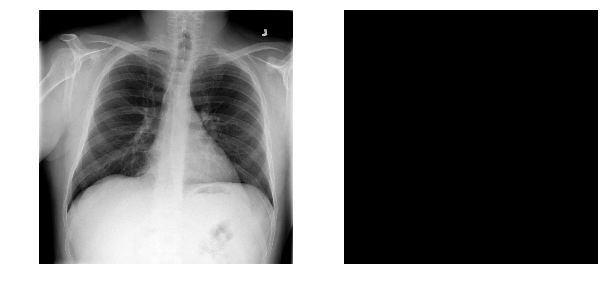

In [25]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))    #Image on the left is the original image
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)    #Image on the right represents area under bounding boxes. If no bounding boxes exist, the image will be black
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

**Image Augmentation**

In [0]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

In [27]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [28]:
%%time

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10,
            layers='all',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: /Pneumonia_Detection/working/pneumonia20190505T0912/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn

In [29]:
#Train with augmentation
%%time
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=20,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 10. LR=0.001

Checkpoint Path: /Pneumonia_Detection/working/pneumonia20190505T0912/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

In [31]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=35,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 20. LR=0.001

Checkpoint Path: /Pneumonia_Detection/working/pneumonia20190505T0912/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

In [0]:
epochs = range(1,len(next(iter(history.values())))+1)
log3 = pd.DataFrame(history, index=epochs)

In [0]:
#Save the loss data in a file
from google.colab import files

log3.to_csv('log3.csv', index=False)
files.download('log3.csv')

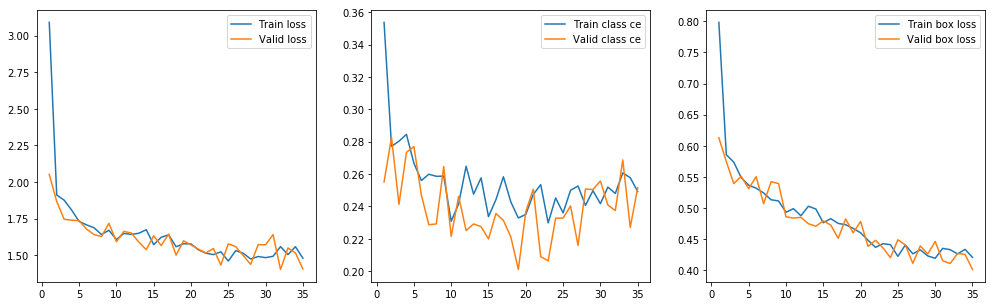

In [34]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [35]:
#Find the best epoch
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 32 1.403719766139984


In [36]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /Pneumonia_Detection/working/pneumonia20190505T0912/mask_rcnn_pneumonia_0032.h5


In [37]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /Pneumonia_Detection/working/pneumonia20190505T0912/mask_rcnn_pneumonia_0032.h5
Re-starting from epoch 32


In [0]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



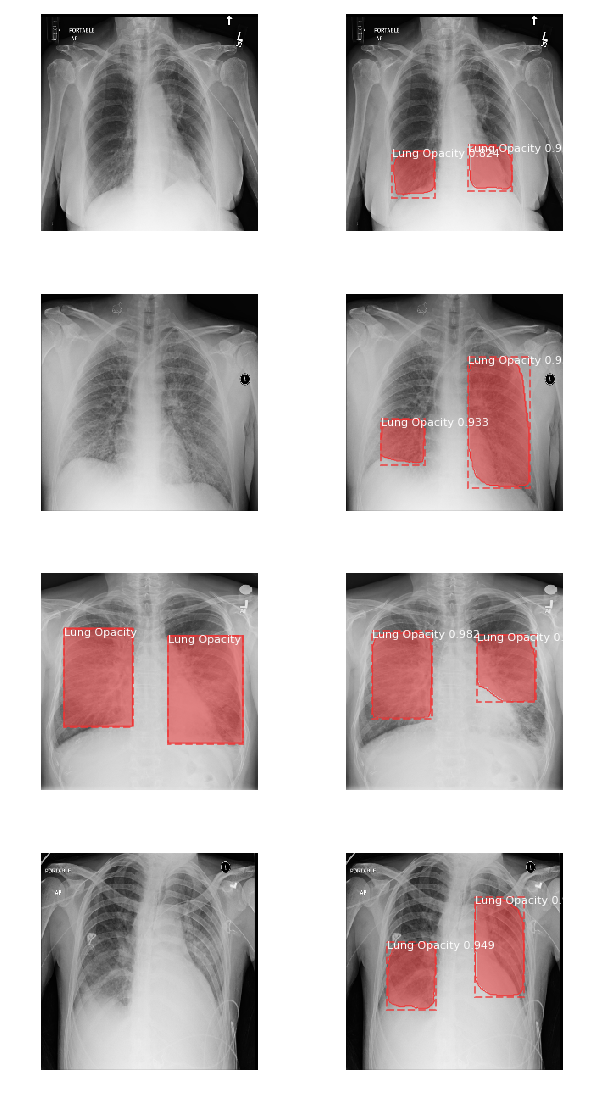

In [39]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [0]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

In [0]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")


In [42]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [08:28<00:00,  5.54it/s]

/Pneumonia_Detection/submission.csv


In [43]:
output = pd.read_csv(submission_fp)
output.head(60)

,patientId,PredictionString
0,19e76f7c-b673-4b33-a385-49f0bb8e4558,NaN
1,24db06a7-86e0-4690-8d57-088ab93d3e04,NaN
2,1b4511a5-9af4-411e-aad9-f005d318cf66,NaN
3,12f430d2-d15c-4191-be63-5dfc4df179ed,NaN
4,13213d41-f74c-4806-a6b0-1703893e5a80,NaN
5,1342a8a2-ca78-4f73-93f1-01c07b298c8c,NaN
6,0e8640ab-2f0b-461d-976a-7d86f128b57a,0.97 140.0 404.0 240.0 300.0 0.97 556.0 488.0...
7,2ea0e3dd-d671-42d0-b5db-0d73c79b4b82,0.96 560.0 156.0 280.0 556.0
8,058240c8-1e00-4f7f-8a13-006aafd538eb,0.98 184.0 356.0 248.0 260.0 0.97 628.0 284.0...
9,02780306-5d72-4377-8183-37c3e0e13e55,0.97 248.0 332.0 228.0 504.0


In [0]:
files.download(submission_fp)